In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind

import re
from scipy.stats import lognorm
# Импортируем необходимые библиотеки:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [7]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [9]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
32971,id_2758,Madrid,"['Spanish', 'Mediterranean']",2760.0,$$ - $$$,92.0,"[['Great late lunch', 'Really good experience ...",/Restaurant_Review-g187514-d7312077-Reviews-El...,d7312077,1,4.0
18776,id_6479,Madrid,NaN,6482.0,NaN,8.0,"[['A must for crisps and nuts fanatics', 'REAL...",/Restaurant_Review-g187514-d9862424-Reviews-He...,d9862424,1,4.0
41621,id_1913,Milan,"['Chinese', 'Japanese', 'Sushi', 'Asian', 'Veg...",1915.0,$$ - $$$,130.0,"[['Good All you can eat', 'That platter of sus...",/Restaurant_Review-g187849-d10720769-Reviews-M...,d10720769,1,4.5
49595,id_2667,Madrid,['Spanish'],2669.0,$$ - $$$,6.0,"[[], []]",/Restaurant_Review-g187514-d13130277-Reviews-P...,d13130277,1,4.5
49664,id_878,Hamburg,NaN,880.0,NaN,32.0,"[['A charming evening', 'Looking for local foo...",/Restaurant_Review-g187331-d7906818-Reviews-Wi...,d7906818,1,4.0


In [10]:
data.rename(columns={'Cuisine Style': 'Cuisine_style',
                     'Price Range': 'Price_range',
                     'Number of Reviews': 'Number_of_reviews',
                     'sample':'Sample'}, inplace=True)
data.columns

Index(['Restaurant_id', 'City', 'Cuisine_style', 'Ranking', 'Price_range',
       'Number_of_reviews', 'Reviews', 'URL_TA', 'ID_TA', 'Sample', 'Rating'],
      dtype='object')

In [11]:
pd.isnull(data).sum()

Restaurant_id            0
City                     0
Cuisine_style        11590
Ranking                  0
Price_range          17361
Number_of_reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
Sample                   0
Rating                   0
dtype: int64

In [12]:

'''функция obj_describe для описания параметров типа object.
Выводит информацию о :
1)пропусках данных
2)количестве встречающихся значений
3)Строит boxplot для оценки влияния признака на распределение целевой переменной'''
def obj_describe(data,column):
    print('пустых значений в колонке ',column," : ",data.loc[:,column].isnull().sum())
    print('Значения в колонке: ',pd.DataFrame(data.loc[:,column].value_counts()))
    #график строим только для тренировочных данных чтобы по нему опре
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x=column, y='Rating', data=data)

'''функция num_value_analiz для анализа основных числовых показателей
Выводит информацию о:
1)min
2)25-й перцентиль
3)медиана
4)среднее
5)max
6)IQR
7)Границы выбросов
'''    
def num_value_analiz(data,column):
    low = data.loc[:,column].min()
    median = data.loc[:,column].median()
    mean = data.loc[:,column].mean()
    hight = data.loc[:,column].max()
    IQR = data.loc[:,column].quantile(0.75) - data.loc[:,column].quantile(0.25)
    perc25 = data.loc[:,column].quantile(0.25)
    perc75 = data.loc[:,column].quantile(0.75)

    print('min : {} \n\r'.format(low),
          '25-й перцентиль: {} \n\r'.format(perc25),
          'медиана: {} \n\r'.format(median),
          'среднее: {} \n\r'.format(mean),
          'max : {} \n\r'.format(hight),
          '75-й перцентиль: {} \n\r'.format(perc75),
          "IQR: {} \n\r".format(IQR),
          "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))


In [13]:
data.Restaurant_id.value_counts()

id_871      19
id_227      19
id_436      19
id_633      19
id_321      18
            ..
id_10514     1
id_14318     1
id_12418     1
id_15330     1
id_14380     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [14]:
s=data.Restaurant_id.value_counts()
multiple_id=s[s>1]

In [15]:
data['Franchise']=data['Restaurant_id'].apply(lambda x: 1 if x in multiple_id else 0)

пустых значений в колонке  Franchise  :  0
Значения в колонке:     Franchise
1      37378
0       2622


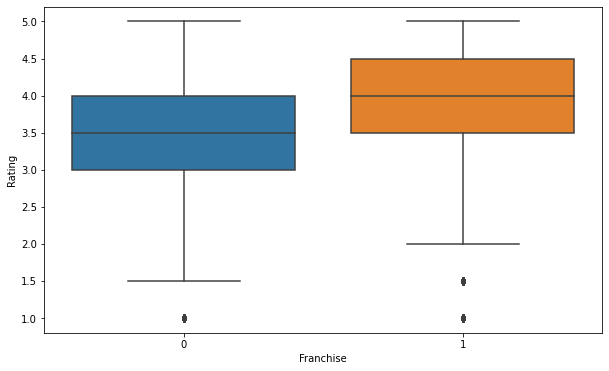

In [16]:
obj_describe(data[data['Sample']==1],'Franchise')

In [17]:
data.Price_range.value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_range, dtype: int64

In [18]:
# Создаем новый признак No_Price
data['No_Price'] = pd.isna(data['Price_range']).astype('int64') 
data[['No_Price','Price_range']][data['No_Price']==1]

,No_Price,Price_range
7,1,NaN
8,1,NaN
9,1,NaN
10,1,NaN
13,1,NaN
...,...,...
49988,1,NaN
49989,1,NaN
49990,1,NaN
49993,1,NaN


In [19]:
dict_values = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price_value']=data['Price_range'].apply(lambda x: dict_values.get(x,x))
print(data[['Price_value','Price_range']])

       Price_value Price_range
0              2.0    $$ - $$$
1              2.0    $$ - $$$
2              2.0    $$ - $$$
3              3.0        $$$$
4              3.0        $$$$
...            ...         ...
49995          2.0    $$ - $$$
49996          2.0    $$ - $$$
49997          NaN         NaN
49998          2.0    $$ - $$$
49999          2.0    $$ - $$$

[50000 rows x 2 columns]


In [20]:
city_list=data.City.unique().tolist()
dict_city_mean_price={}

for i in city_list:
    dict_city_mean_price[i]=data[data['City']==i].Price_value.median()
    
dict_city_mean_price

{'Paris': 2.0,
 'Helsinki': 2.0,
 'Edinburgh': 2.0,
 'London': 2.0,
 'Bratislava': 2.0,
 'Lisbon': 2.0,
 'Budapest': 2.0,
 'Stockholm': 2.0,
 'Rome': 2.0,
 'Milan': 2.0,
 'Munich': 2.0,
 'Hamburg': 2.0,
 'Prague': 2.0,
 'Vienna': 2.0,
 'Dublin': 2.0,
 'Barcelona': 2.0,
 'Brussels': 2.0,
 'Madrid': 2.0,
 'Oslo': 2.0,
 'Amsterdam': 2.0,
 'Berlin': 2.0,
 'Lyon': 2.0,
 'Athens': 2.0,
 'Warsaw': 2.0,
 'Oporto': 2.0,
 'Krakow': 2.0,
 'Copenhagen': 2.0,
 'Luxembourg': 2.0,
 'Zurich': 2.0,
 'Geneva': 2.0,
 'Ljubljana': 2.0}

In [21]:
indexes=data[data.Price_value.isna()].index.tolist()
for i in indexes:
    data.loc[i,'Price_value']=dict_city_mean_price[data.loc[i,'City']]
    
data[['Price_value','Price_range']]

,Price_value,Price_range
0,2.0,$$ - $$$
1,2.0,$$ - $$$
2,2.0,$$ - $$$
3,3.0,$$$$
4,3.0,$$$$
...,...,...
49995,2.0,$$ - $$$
49996,2.0,$$ - $$$
49997,2.0,NaN
49998,2.0,$$ - $$$


пустых значений в колонке  Price_value  :  0
Значения в колонке:       Price_value
2.0        32298
1.0         6279
3.0         1423


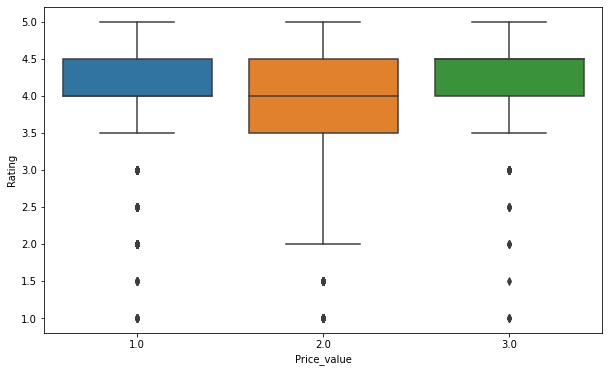

In [22]:
obj_describe(data[data['Sample']==1],'Price_value')

In [23]:
num_value_analiz(data,'Price_value')

min : 1.0 
 25-й перцентиль: 2.0 
 медиана: 2.0 
 среднее: 1.87932 
 max : 3.0 
 75-й перцентиль: 2.0 
 IQR: 0.0 
 Границы выбросов: [2.0, 2.0].


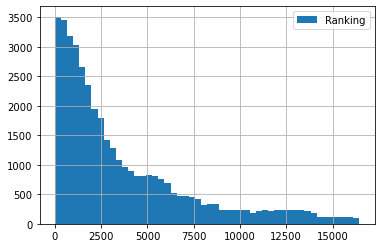

In [24]:
data[data['Sample']==1].Ranking.hist(legend=True,bins=50)

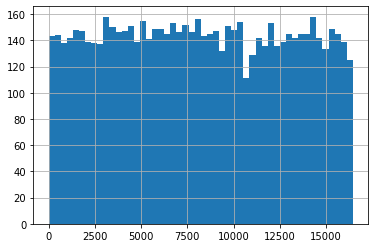

In [25]:
data[data['City']=='London']['Ranking'].hist(bins=50)

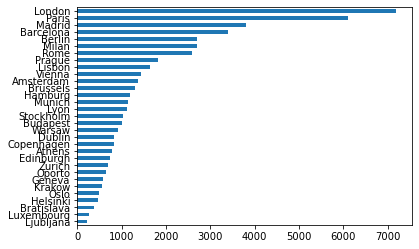

In [26]:
data['City'].value_counts(ascending=True).plot(kind='barh')

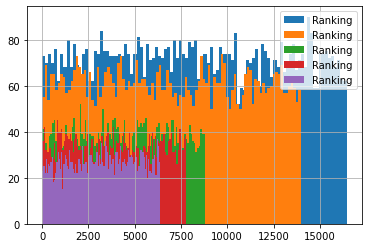

In [27]:
top_rest_city=(data.City.value_counts())[0:5].index
for x in top_rest_city:
    data['Ranking'][data['City'] == x].hist(bins=100,legend=True)
plt.show()

In [28]:
dict_mean_city_rank={}
for i in city_list:
    dict_mean_city_rank[i]=round(data[data['City']==i].Ranking.mean(),4)
dict_mean_city_rank

{'Paris': 6938.5571,
 'Helsinki': 564.2316,
 'Edinburgh': 885.1302,
 'London': 8169.7074,
 'Bratislava': 462.4289,
 'Lisbon': 1867.3303,
 'Budapest': 1219.0617,
 'Stockholm': 1237.4821,
 'Rome': 2970.7331,
 'Milan': 3106.0278,
 'Munich': 1370.2978,
 'Hamburg': 1375.4098,
 'Prague': 2086.9796,
 'Vienna': 1711.2758,
 'Dublin': 972.128,
 'Barcelona': 3879.4227,
 'Brussels': 1541.9018,
 'Madrid': 4388.5164,
 'Oslo': 552.5697,
 'Amsterdam': 1591.5897,
 'Berlin': 3255.4177,
 'Lyon': 1303.9023,
 'Athens': 880.2139,
 'Warsaw': 1055.1935,
 'Oporto': 752.0343,
 'Krakow': 616.2671,
 'Copenhagen': 982.1477,
 'Luxembourg': 308.1597,
 'Zurich': 794.2803,
 'Geneva': 713.2271,
 'Ljubljana': 234.509}

In [29]:
# посчитаем сколько ресторанов в каждом городе
rest_count=data.City.value_counts().to_dict()

def city_counter(city):
    return rest_count[city]

# создадим новый параметр
data['City_rest']=data['City'].apply(city_counter)
print(data[['City','City_rest']])
print(rest_count)

             City  City_rest
0           Paris       6108
1        Helsinki        475
2       Edinburgh        745
3          London       7193
4      Bratislava        380
...           ...        ...
49995       Milan       2694
49996       Paris       6108
49997   Stockholm       1033
49998      Warsaw        925
49999       Milan       2694

[50000 rows x 2 columns]
{'London': 7193, 'Paris': 6108, 'Madrid': 3813, 'Barcelona': 3395, 'Berlin': 2705, 'Milan': 2694, 'Rome': 2589, 'Prague': 1816, 'Lisbon': 1647, 'Vienna': 1443, 'Amsterdam': 1372, 'Brussels': 1314, 'Hamburg': 1186, 'Munich': 1145, 'Lyon': 1126, 'Stockholm': 1033, 'Budapest': 1021, 'Warsaw': 925, 'Dublin': 836, 'Copenhagen': 819, 'Athens': 776, 'Edinburgh': 745, 'Zurich': 685, 'Oporto': 642, 'Geneva': 590, 'Krakow': 554, 'Oslo': 488, 'Helsinki': 475, 'Bratislava': 380, 'Luxembourg': 263, 'Ljubljana': 222}


In [30]:
# сделаем для каждого города средний ранг чтобы относительно него можно 
# было сравнивать локально по городам
data['mean_City_rank'] = data['City'].apply(lambda x: dict_mean_city_rank[x])

In [31]:
# делаем для каждого ресторана новый локальный ранг
# data['norming_rank'] = (data['Ranking'] - data['mean_City_rank']) / data['City_rest']
data['norming_rank'] = data['Ranking'] / data['City_rest']

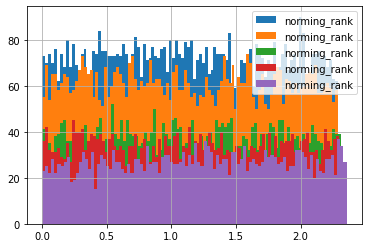

In [32]:
top_rest_city=(data.City.value_counts())[0:5].index
for x in top_rest_city:
    data['norming_rank'][data['City'] == x].hist(bins=100,legend=True)
plt.show()

пустых значений в колонке  City  :  0
Значения в колонке:              City
London      5757
Paris       4897
Madrid      3108
Barcelona   2734
Berlin      2155
Milan       2133
Rome        2078
Prague      1443
Lisbon      1300
Vienna      1166
Amsterdam   1086
Brussels    1060
Hamburg      949
Munich       893
Lyon         892
Stockholm    820
Budapest     816
Warsaw       727
Dublin       673
Copenhagen   659
Athens       628
Edinburgh    596
Zurich       538
Oporto       513
Geneva       481
Krakow       443
Oslo         385
Helsinki     376
Bratislava   301
Luxembourg   210
Ljubljana    183


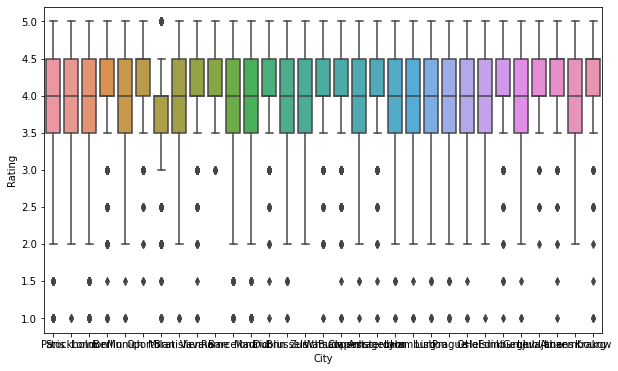

In [33]:
obj_describe(data[data['Sample']==1],'City')

In [34]:
data.City=data.City.apply(lambda x: x.lower())
data.head(5)

,Restaurant_id,City,Cuisine_style,Ranking,Price_range,Number_of_reviews,Reviews,URL_TA,ID_TA,Sample,Rating,Franchise,No_Price,Price_value,City_rest,mean_City_rank,norming_rank
0,id_0,paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,0,2.0,6108,6938.5571,2.122299
1,id_1,helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,0,2.0,475,564.2316,0.223158
2,id_2,edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,0,2.0,745,885.1302,1.087248
3,id_3,london,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,1,0,3.0,7193,8169.7074,0.232031
4,id_4,bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,1,0,3.0,380,462.4289,0.097368


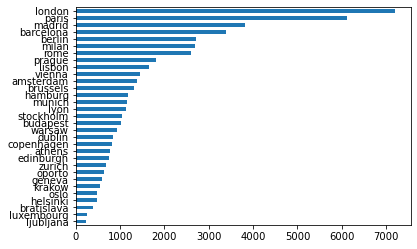

In [35]:
data['City'].value_counts(ascending=True).plot(kind='barh')

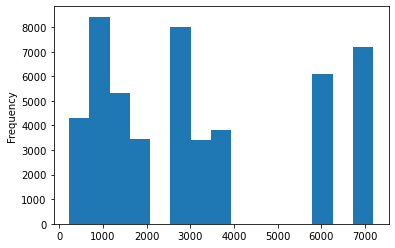

In [36]:
data.City_rest.plot(kind='hist',bins=15)

In [37]:
# сделаем анализ границ и расчитаем их точные значения
num_value_analiz(data,'City_rest')
# построение гистограммы с обозначением выбросов считаю нецелесообразным т.к.
# Как мы видели из распределения количества ресторанов по городам,
# в европейских столицах как более богатых городах просто больше ресторанов))

min : 222 
 25-й перцентиль: 1145.0 
 медиана: 2694.0 
 среднее: 3196.6344 
 max : 7193 
 75-й перцентиль: 6108.0 
 IQR: 4963.0 
 Границы выбросов: [-6299.5, 13552.5].


In [38]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   Cuisine_style      38410 non-null  object 
 2   Ranking            50000 non-null  float64
 3   Price_range        32639 non-null  object 
 4   Number_of_reviews  46800 non-null  float64
 5   Reviews            49998 non-null  object 
 6   URL_TA             50000 non-null  object 
 7   ID_TA              50000 non-null  object 
 8   Sample             50000 non-null  int64  
 9   Rating             50000 non-null  float64
 10  Franchise          50000 non-null  int64  
 11  No_Price           50000 non-null  int64  
 12  Price_value        50000 non-null  float64
 13  City_rest          50000 non-null  int64  
 14  mean_City_rank     50000 non-null  float64
 15  norming_rank       50000 non-null  float64
 16  City_amsterdam     500

In [39]:
data.Cuisine_style.value_counts()

['Italian']                                                                                                    1332
['French']                                                                                                     1019
['Spanish']                                                                                                     860
['French', 'European']                                                                                          503
['Cafe']                                                                                                        500
                                                                                                               ... 
['Italian', 'European', 'Nepali', 'Asian', 'Vegetarian Friendly']                                                 1
['Italian', 'Bar', 'Pizza', 'European', 'Czech', 'Central European', 'Vegetarian Friendly']                       1
['International', 'Chinese', 'Asian', 'Vegetarian Friendly', 'Gluten Fre

In [40]:
# Создаем новый признак No_Cuisine_style
data['No_Cuisine_style'] = pd.isna(data['Cuisine_style']).astype('int64') 
data[['No_Cuisine_style','Cuisine_style']][data['No_Cuisine_style']==1]

,No_Cuisine_style,Cuisine_style
7,1,NaN
10,1,NaN
13,1,NaN
18,1,NaN
20,1,NaN
...,...,...
49981,1,NaN
49983,1,NaN
49986,1,NaN
49988,1,NaN


пустых значений в колонке  No_Cuisine_style  :  0
Значения в колонке:     No_Cuisine_style
0             30717
1              9283


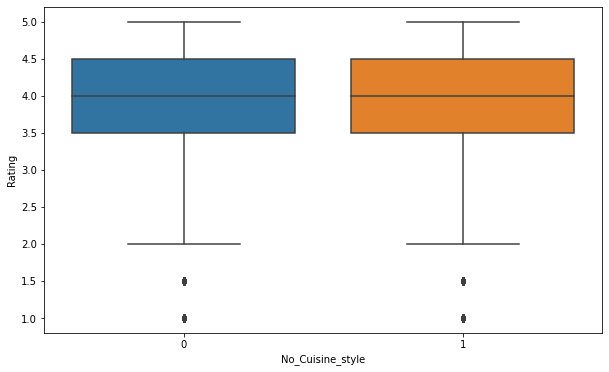

In [41]:
obj_describe(data[data['Sample']==1],'No_Cuisine_style')

In [42]:
#Создаем новый признак Cuisine_quant
# там где нет стиля кухни будет соответственно стоять 0
data['Cuisine_quant']=data['Cuisine_style'].apply(lambda x: len(re.findall(r"'(\b.*?\b)'",str(x))))
data[['Cuisine_quant','Cuisine_style']][data['Cuisine_quant']==0]

,Cuisine_quant,Cuisine_style
7,0,NaN
10,0,NaN
13,0,NaN
18,0,NaN
20,0,NaN
...,...,...
49981,0,NaN
49983,0,NaN
49986,0,NaN
49988,0,NaN


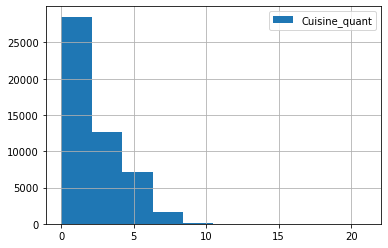

In [43]:
data.Cuisine_quant.hist(legend=True)

пустых значений в колонке  Cuisine_quant  :  0
Значения в колонке:      Cuisine_quant
0            9283
1            7264
2            6294
3            5306
4            4799
5            3606
6            2043
7            1022
8             283
9              76
10             19
11              3
21              1
13              1


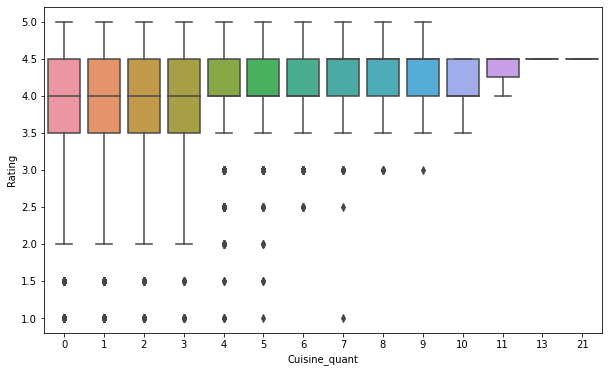

In [44]:
obj_describe(data[data['Sample']==1],'Cuisine_quant')

In [45]:
num_value_analiz(data,'Cuisine_quant')

min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 2.39352 
 max : 21 
 75-й перцентиль: 4.0 
 IQR: 3.0 
 Границы выбросов: [-3.5, 8.5].


In [46]:
data['Cuisine_style'] = data['Cuisine_style'].fillna("['Other']")
data.Cuisine_style.value_counts()

['Other']                                                                                                      11590
['Italian']                                                                                                     1332
['French']                                                                                                      1019
['Spanish']                                                                                                      860
['French', 'European']                                                                                           503
                                                                                                               ...  
['Italian', 'European', 'Nepali', 'Asian', 'Vegetarian Friendly']                                                  1
['Italian', 'Bar', 'Pizza', 'European', 'Czech', 'Central European', 'Vegetarian Friendly']                        1
['International', 'Chinese', 'Asian', 'Vegetarian Friendly', 'Gl

In [47]:
#Обработаем значения признака
data['Cuisine_style']=data['Cuisine_style'].str.findall(r"'(\b.*?\b)'")

In [48]:
#составим список всех уникальных кухонь
Trash_styles = data['Cuisine_style'].tolist()
Trash_styles
clear_styles=[]
for style in Trash_styles:
    clear_styles.extend(style)
clear_styles=set(clear_styles)
print(clear_styles)

{'Filipino', 'Middle Eastern', 'Lebanese', 'Singaporean', 'Mexican', 'Persian', 'Eastern European', 'British', 'Uzbek', 'Moroccan', 'New Zealand', 'Native American', 'Vegetarian Friendly', 'Balti', 'Steakhouse', 'African', 'Grill', 'Korean', 'Taiwanese', 'Albanian', 'Latvian', 'Chilean', 'Ethiopian', 'Egyptian', 'Central European', 'Pub', 'Brew Pub', 'Contemporary', 'Fujian', 'Turkish', 'Bar', 'Hawaiian', 'Swedish', 'Mediterranean', 'Central Asian', 'Brazilian', 'Vegan Options', 'Cafe', 'Peruvian', 'Norwegian', 'Slovenian', 'Kosher', 'Dutch', 'Greek', 'Mongolian', 'Pizza', 'Indian', 'Austrian', 'Central American', 'Chinese', 'Tibetan', 'International', 'Thai', 'Cambodian', 'Soups', 'Minority Chinese', 'Other', 'Ecuadorean', 'Ukrainian', 'Armenian', 'Fast Food', 'Polynesian', 'Croatian', 'Romanian', 'Diner', 'Sri Lankan', 'Southwestern', 'Polish', 'German', 'Azerbaijani', 'Portuguese', 'Colombian', 'Malaysian', 'Asian', 'Venezuelan', 'Cajun & Creole', 'Georgian', 'Argentinean', 'Danish'

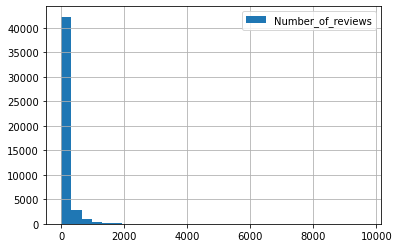

In [49]:
data.Number_of_reviews.hist(legend=True,bins=30)

In [50]:
num_value_analiz(data,'Number_of_reviews')

min : 2.0 
 25-й перцентиль: 9.0 
 медиана: 33.0 
 среднее: 124.47119658119658 
 max : 9660.0 
 75-й перцентиль: 115.0 
 IQR: 106.0 
 Границы выбросов: [-150.0, 274.0].


In [51]:
#Создаем новый признак No_Cuisine_style
data['No_reviews'] = pd.isna(data['Number_of_reviews']).astype('int64') 
data[['No_reviews','Number_of_reviews']][data['No_Cuisine_style']==1]

,No_reviews,Number_of_reviews
7,1,NaN
10,0,306.0
13,0,30.0
18,0,2.0
20,0,8.0
...,...,...
49981,0,29.0
49983,0,2.0
49986,1,NaN
49988,1,NaN


пустых значений в колонке  No_reviews  :  0
Значения в колонке:     No_reviews
0       37457
1        2543


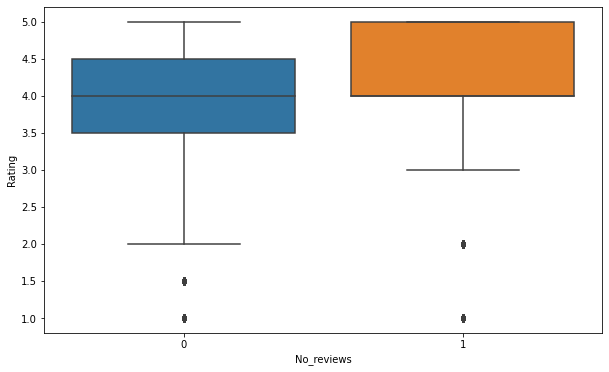

In [52]:
obj_describe(data[data['Sample']==1],'No_reviews')

Text(0, 0.5, 'Number_of_reviews')

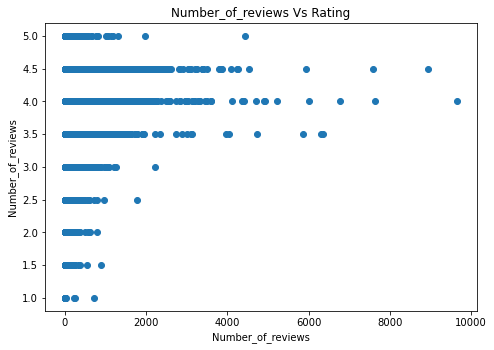

In [53]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x = data[data['Sample']==1]['Number_of_reviews'], y = data[data['Sample']==1]['Rating'], marker = 'o')
axes.set_title('Number_of_reviews Vs Rating')
axes.set_xlabel('Number_of_reviews')
axes.set_ylabel('Number_of_reviews')

In [54]:
#Я решил заполнить пропуски 0
data['Number_of_reviews'] = data['Number_of_reviews'].fillna(0)

In [55]:
print(data['Reviews'][0:2])

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
Name: Reviews, dtype: object


In [56]:
data['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [57]:
pd.isnull(data['Reviews']).sum()

2

In [58]:
len(data[data['Reviews']=='[[], []]'])

8112

In [59]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [60]:
data['No_reviews'] = (data['Reviews']=='[[], []]').astype('float64')

In [61]:
#создаем новый параметр с датами
data['Review_dates'] = data['Reviews'].str.findall('\d+/\d+/\d+')

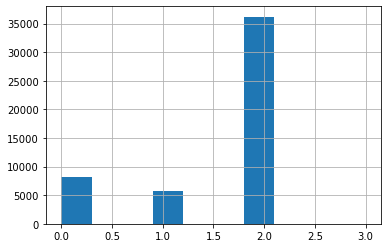

In [62]:
data['Review_dates'].apply(lambda x: len(x)).hist()

In [63]:
data[data['Review_dates'].apply(lambda x: len(x))==1]['Reviews']

12       [['You always feel very Welcome at this cozy.....
31                    [['Very good food'], ['09/24/2017']]
48                            [['Thomas'], ['01/06/2016']]
50       [['The best in Budapest so far'], ['03/05/2017']]
55       [['Coffee was fine - and as it says low price'...
                               ...                        
49972             [['Personal expirence'], ['10/27/2017']]
49974    [['Nice place to eat and chill'], ['08/29/2016']]
49983     [['Italian food, as in Italy!'], ['05/24/2015']]
49984          [['Good Cookies and more'], ['11/03/2016']]
49989             [['I love this place!'], ['08/24/2015']]
Name: Reviews, Length: 5680, dtype: object

In [64]:
data['Dates_count']=data['Review_dates'].apply(lambda x: len(x))
num_value_analiz(data,'Dates_count')

min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 1.56192 
 max : 3 
 75-й перцентиль: 2.0 
 IQR: 1.0 
 Границы выбросов: [-0.5, 3.5].


In [65]:
data[data['Dates_count']==3]['Review_dates']

2221      [21/10/17, 12/22/2017, 10/19/2017]
3809     [30/5/2017, 04/13/2017, 05/30/2017]
19254     [3/1/2017, 06/02/2017, 01/03/2017]
33348    [29/9/2016, 09/30/2016, 08/25/2016]
Name: Review_dates, dtype: object

In [66]:
data['Dates_count'].Review_dates = data[data['Dates_count']==3].Review_dates.apply(lambda x: x.pop(0))
data['Dates_count']=data['Review_dates'].apply(lambda x: len(x))
num_value_analiz(data,'Dates_count')

min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 1.56184 
 max : 2 
 75-й перцентиль: 2.0 
 IQR: 1.0 
 Границы выбросов: [-0.5, 3.5].


In [67]:
data.Dates_count.value_counts()

2    36206
0     8114
1     5680
Name: Dates_count, dtype: int64

пустых значений в колонке  Dates_count  :  0
Значения в колонке:     Dates_count
2        28973
0         6471
1         4556


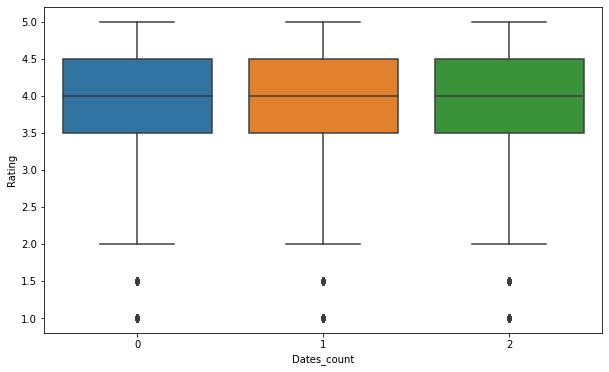

In [68]:
obj_describe(data[data['Sample']==1],'Dates_count')

In [69]:
def last_review(row):
    if row['Review_dates'] == []:
        return None
    return (pd.datetime.now() - pd.to_datetime(row['Review_dates']).max()).days



data['last_review'] = data.apply(last_review, axis = 1)

data['last_review']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


0           NaN
1        1008.0
2         985.0
3        1007.0
4         943.0
          ...  
49995     997.0
49996     992.0
49997    1405.0
49998    1155.0
49999    1682.0
Name: last_review, Length: 50000, dtype: float64

In [70]:
num_value_analiz(data,'last_review')

min : 925.0 
 25-й перцентиль: 1004.0 
 медиана: 1078.0 
 среднее: 1215.0453612185456 
 max : 5984.0 
 75-й перцентиль: 1262.0 
 IQR: 258.0 
 Границы выбросов: [617.0, 1649.0].


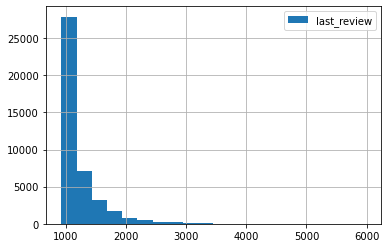

In [71]:
data.last_review.hist(legend=True,bins=20)

In [72]:
data['last_review'] = data['last_review'].fillna(0)

In [73]:
def between_reviews(row):
    if row['Review_dates'] == []:
        return None
    return (pd.to_datetime(row['Review_dates']).max() - pd.to_datetime(row['Review_dates']).min()).days

data['between_reviews'] = data[data['Dates_count']==2].apply(between_reviews, axis = 1)

data[['between_reviews','Dates_count','Review_dates']]

,between_reviews,Dates_count,Review_dates
0,NaN,0,[]
1,37.0,2,"[12/05/2017, 10/29/2017]"
2,22.0,2,"[12/28/2017, 12/06/2017]"
3,14.0,2,"[12/06/2017, 11/22/2017]"
4,15.0,2,"[02/08/2018, 01/24/2018]"
...,...,...,...
49995,34.0,2,"[12/16/2017, 11/12/2017]"
49996,9.0,2,"[12/21/2017, 12/12/2017]"
49997,3127.0,2,"[11/03/2016, 04/12/2008]"
49998,23.0,2,"[07/11/2017, 06/18/2017]"


In [74]:
num_value_analiz(data,'between_reviews')

min : 0.0 
 25-й перцентиль: 20.0 
 медиана: 67.0 
 среднее: 142.54883168535602 
 max : 3296.0 
 75-й перцентиль: 173.0 
 IQR: 153.0 
 Границы выбросов: [-209.5, 402.5].


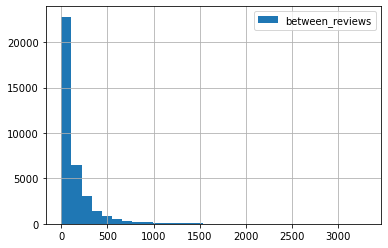

In [75]:
data.between_reviews.hist(legend=True,bins=30)

In [76]:
data['between_reviews'] = data['between_reviews'].fillna(0)

In [77]:
data['single_review'] = (data['Dates_count']==1).astype('float64')

пустых значений в колонке  single_review  :  0
Значения в колонке:       single_review
0.0          35444
1.0           4556


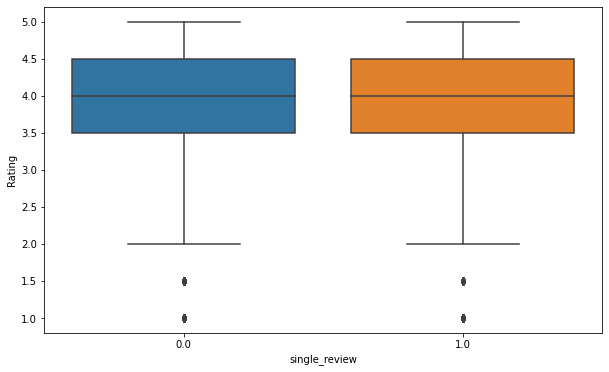

In [78]:
obj_describe(data[data['Sample']==1],'single_review')

In [79]:
data.drop(['Restaurant_id', 'City', 'Cuisine_style', 'Price_range', 'Reviews', 'URL_TA', 'ID_TA', 'Review_dates'], axis=1, inplace=True, errors='ignore')

In [80]:
data_new=data.copy()
def get_stat_dif(column):
    cols = data[data['Sample']==1].loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data[data['Sample']==1].loc[data_new.loc[:, column] == comb[0], 'Rating'],
                     data[data['Sample']==1].loc[data_new.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
        else:
            print('Не найдены статистически значимые различия для колонки', column)
            break

            
for col in data_new.columns.tolist():
     get_stat_dif(col)

Не найдены статистически значимые различия для колонки Ranking
Не найдены статистически значимые различия для колонки Number_of_reviews
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различия для колонки Rating
Найдены статистически значимые различи

In [81]:
data_new=data.copy()
data_new = pd.get_dummies(data_new, columns=[ 'Price_value',], dummy_na=False)
data_new.drop(['Price_value_3.0','No_reviews','Franchise','No_Cuisine_style','City_rest','mean_City_rank','Cuisine_quant','Dates_count','single_review','City_nan','City_paris','City_london','City_helsinki','City_hamburg','City_zurich','City_geneva','City_luxembourg','City_bratislava','City_copenhagen'], axis=1, inplace=True, errors='ignore')
data_new.columns
columns_list=data_new.columns.tolist()
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Number_of_reviews  50000 non-null  float64
 2   Sample             50000 non-null  int64  
 3   Rating             50000 non-null  float64
 4   No_Price           50000 non-null  int64  
 5   norming_rank       50000 non-null  float64
 6   City_amsterdam     50000 non-null  uint8  
 7   City_athens        50000 non-null  uint8  
 8   City_barcelona     50000 non-null  uint8  
 9   City_berlin        50000 non-null  uint8  
 10  City_brussels      50000 non-null  uint8  
 11  City_budapest      50000 non-null  uint8  
 12  City_dublin        50000 non-null  uint8  
 13  City_edinburgh     50000 non-null  uint8  
 14  City_krakow        50000 non-null  uint8  
 15  City_lisbon        50000 non-null  uint8  
 16  City_ljubljana     500

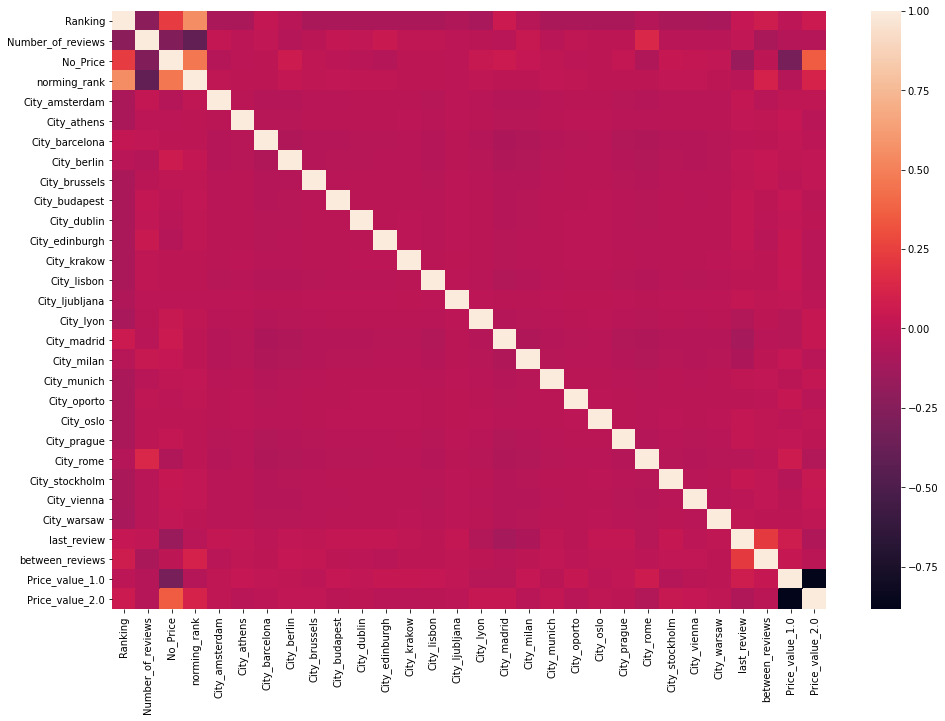

In [82]:
plt.rcParams['figure.figsize'] = (16,11)
sns.heatmap(data_new.drop(['Sample','Rating'], axis=1).corr(),)

In [83]:
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(data_new.columns):
    if i not in ['Rating','Sample']:
        scaler = StandardScaler()
        scaler.fit(data_new[[i ]])
        data_new[i] = scaler.transform(data_new[[i]])


In [84]:
train_data = data_new.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data_new.query('Sample == 0').drop(['Sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [86]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 31), (40000, 31), (40000, 30), (32000, 30), (8000, 30))

In [87]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [88]:

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [89]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.204731875


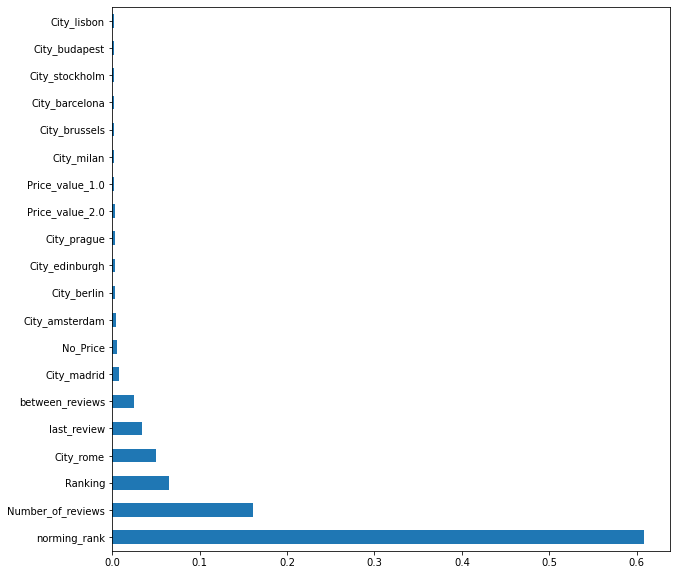

In [90]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission

In [91]:
train_data = data_new.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data_new.query('Sample == 0').drop(['Sample','Rating'], axis=1)
y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [92]:
sample_submission.shape, test_data.shape, X.shape, y.shape

((10000, 2), (10000, 30), (40000, 30), (40000,))

In [93]:
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [94]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [95]:
predict_submission

array([3.215, 4.335, 4.46 , ..., 3.025, 4.08 , 4.335])

In [96]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.215
1,id_1,4.335
2,id_2,4.460
3,id_3,4.240
4,id_4,4.505
5,id_5,4.315
6,id_6,1.475
7,id_7,2.570
8,id_8,4.045
9,id_9,4.615


In [97]:
kaggle competitions submit -c sf-dst-restaurant-rating -f submission.csv -m "Message"

SyntaxError: invalid syntax (<ipython-input-97-e81183ab69f8>, line 1)